# OCR 
- Tesseract Model:
training Google Tesseract pre-train model with 50 Vietnamese fonts
- Pre-processing:
using "imgtxtenh" library to preprocess an image. The function of 'imgtxtenh' is to clean/enhance noisy scanned text images.
- Image segmentation:
spliting an image into many rows of text. Inheriting the result of CRAFT model and G-DBSCAN(clustering algorithm)

# Pre-processing:
- Install imgtxtenh following this link: https://github.com/mauvilsa/imgtxtenh
- Run command: ./imgtxtenh -p [input_image]  [output_image]

# Image segmentation:

Notebook: from beginning to clustering stage

# Image to text:
Notebook: prediction stage


# Trình tự
- Tiền xử lý trên toàn bộ bức ảnh gốc với imgtxtenh để lọc nhiễu và background
- Khởi tạo thông số  cho craft model
- Dùng craft pretrain model dự đoán vị trí các từ trong ảnh sau khi lọc nhiễu, xoay ảnh nếu cần thiết
- Nhóm các từ theo hàng với G-DBSCAN(lưu ý 2 thông số xác định vùng lân cận của giải thuật)
- Bóc tách từng dữ liệu theo hàng, tiền xử lý đồng thời dùng tesseract model chuyển từng dòng ảnh sang chữ viết

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
%cd "/content/drive/My Drive/ocr_demo_code"

/content/drive/My Drive/ocr_demo_code


In [88]:
!git clone https://github.com/mauvilsa/imgtxtenh

fatal: destination path 'imgtxtenh' already exists and is not an empty directory.


In [89]:
import sys
import os
import time
import argparse

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from PIL import Image

import cv2
from skimage import io
import numpy as np
import craft_utils
import imgproc
import file_utils
import json
import zipfile

from craft import CRAFT
from collections import OrderedDict
import copy
import math

# CRAFT  

In [90]:

def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

def str2bool(v):
    return v.lower() in ("yes", "y", "true", "t", "1")

In [91]:
def test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly, refine_net=None):
    t0 = time.time()

    # resize
    img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=mag_ratio)
    ratio_h = ratio_w = 1 / target_ratio

    # preprocessing
    x = imgproc.normalizeMeanVariance(img_resized)
    x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
    x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
    if cuda:
        x = x.cuda()

    # forward pass
    with torch.no_grad():
        y, feature = net(x)

    # make score and link map
    score_text = y[0,:,:,0].cpu().data.numpy()
    score_link = y[0,:,:,1].cpu().data.numpy()

    # refine link
    if refine_net is not None:
        with torch.no_grad():
            y_refiner = refine_net(y, feature)
        score_link = y_refiner[0,:,:,0].cpu().data.numpy()

    t0 = time.time() - t0
    t1 = time.time()

    # Post-processing
    boxes, polys = craft_utils.getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text, poly)

    # coordinate adjustment
    boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)
    polys = craft_utils.adjustResultCoordinates(polys, ratio_w, ratio_h)
    for k in range(len(polys)):
        if polys[k] is None: polys[k] = boxes[k]

    t1 = time.time() - t1

    # render results (optional)
    render_img = score_text.copy()
    render_img = np.hstack((render_img, score_link))
    ret_score_text = imgproc.cvt2HeatmapImg(render_img)

    if show_time : print("\ninfer/postproc time : {:.3f}/{:.3f}".format(t0, t1))

    return boxes, polys, ret_score_text

# G-DBSCAN

In [92]:
class Point:
    '''
    Each point have 2 main values: coordinate(lat, long) and cluster_id
    '''
    def __init__(self, x, y, id):
        self.x = x
        self.y = y
        self.id = id
        self.cluster_id = UNCLASSIFIED

    def __repr__(self):
        return '(x:{}, y:{}, id:{}, cluster:{})' \
            .format(self.x, self.y, self.id, self.cluster_id)


def n_pred(p1, p2):
#     return (p1.x - p2.x)**2/160000 + (p1.y - p2.y)**2/2500 <= 1
#     print(p1.x -p2.x)
#     print(p1.y -p2.y)
#     return (p1.x - p2.x)**2/50000 + (p1.y - p2.y)**2/1500 <= 1
#     return (p1.x - p2.x)**2/20000 + (p1.y - p2.y)**2/1300 <= 1
#     return (p1.x - p2.x)**2/2000 + (p1.y - p2.y)**2/130 <= 1
#     return (p1.x - p2.x)**2/3500 + (p1.y - p2.y)**2/150 <= 1
#     return (p1.x - p2.x)**2/7000 + (p1.y - p2.y)**2/1300 <= 1
#     return (p1.x - p2.x)**2/8000 + (p1.y - p2.y)**2/300 <= 1
#     return (p1.x - p2.x)**2/17000 + (p1.y - p2.y)**2/300 <= 1
#     return (p1.x - p2.x)**2/13000 + (p1.y - p2.y)**2/250 <= 1
    return (p1.x - p2.x)**2/15000 + (p1.y - p2.y)**2/180 <= 1


def w_card(points):
    return len(points)

In [93]:
UNCLASSIFIED = -2
NOISE = -1

def GDBSCAN(points, n_pred, min_card, w_card):
    points = copy.deepcopy(points)
    cluster_id = 0
    for point in points:
        if point.cluster_id == UNCLASSIFIED:
            if _expand_cluster(points, point, cluster_id, n_pred, min_card,
                               w_card):
                cluster_id = cluster_id + 1
    clusters = {}
    for point in points:
        key = point.cluster_id
        if key in clusters:
            clusters[key].append(point)
        else:
            clusters[key] = [point]
    return list(clusters.values())


def _expand_cluster(points, point, cluster_id, n_pred, min_card, w_card):
    if not _in_selection(w_card, point):
        points.change_cluster_id(point, UNCLASSIFIED)
        return False

    seeds = points.neighborhood(point, n_pred)
    if not _core_point(w_card, min_card, seeds):
        points.change_cluster_id(point, NOISE)
        return False

    points.change_cluster_ids(seeds, cluster_id)
    seeds.remove(point)

    while len(seeds) > 0:
        current_point = seeds[0]
        result = points.neighborhood(current_point, n_pred)
        if w_card(result) >= min_card:
            for p in result:
                if w_card([p]) > 0 and p.cluster_id in [UNCLASSIFIED, NOISE]:
                    if p.cluster_id == UNCLASSIFIED:
                        seeds.append(p)
                    points.change_cluster_id(p, cluster_id)
        seeds.remove(current_point)
    return True


def _in_selection(w_card, point):
    return w_card([point]) > 0


def _core_point(w_card, min_card, points):
    return w_card(points) >= min_card


class Points:
    'Contain list of Point'
    def __init__(self, points):
        self.points = points

    def __iter__(self):
        for point in self.points:
            yield point

    def __repr__(self):
        return str(self.points)

    def get(self, index):
        return self.points[index]

    def neighborhood(self, point, n_pred):
        return list(filter(lambda x: n_pred(point, x), self.points))

    def change_cluster_ids(self, points, value):
        for point in points:
            self.change_cluster_id(point, value)

    def change_cluster_id(self, point, value):
        index = (self.points).index(point)
        self.points[index].cluster_id = value

    def labels(self):
        return set(map(lambda x: x.cluster_id, self.points))

# Word detection

In [94]:
# Initialize CRAFT parameters
text_threshold = 0.7
low_text = 0.4
link_threshold =0.4
# cuda = True
cuda=False
canvas_size =1280
mag_ratio =1.5
poly=False
refine=False
show_time=False
refine_net = None
trained_model_path = './craft_mlt_25k.pth'

Load CRAFT pre-train model

Load data and apply CRAFT model to recognize word blocks on an image

In [95]:
net = CRAFT()
net.load_state_dict(copyStateDict(torch.load(trained_model_path, map_location='cpu')))
net.eval()

CRAFT(
  (basenet): vgg16_bn(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (slice2): Sequential(
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kerne

In [99]:
# Load image from it'path
image_path = './imgtxtenh/x9pre.png'
image = imgproc.loadImage(image_path)

In [97]:
# If you need rotate an image, use imutils library and call rotate method with specified number of angle  degrees about the center of the image
import imutils
image = imutils.rotate(image, -3)

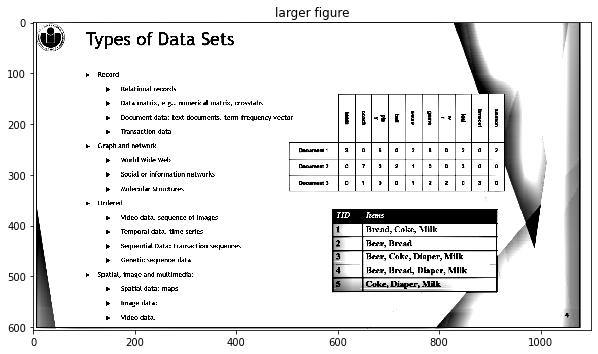

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt

fig2 = plt.figure(figsize = (10,10)) # create a 10 x 10 figure 
ax3 = fig2.add_subplot(111)
ax3.imshow(image, interpolation='none')
ax3.set_title('larger figure')

plt.show()

In [101]:
# Apply predict function to the image then get the word bounding boxes
bboxes, polys, score_text = test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly, refine_net)

In [102]:
# Save results of CRAFT model prediction to the directory 
file_utils.saveResult(image_path, image[:,:,::-1], bboxes, dirname='./craft_result/')

In [103]:
# Compute coordinate of central point in each box returned by CRAFT
poly_indexes = {}
central_poly_indexes = []
for i in range(len(polys)):
  poly_indexes[i] =  polys[i]
  x_central = (polys[i][0][0] + polys[i][1][0] +polys[i][2][0] + polys[i][3][0])/4
  y_central = (polys[i][0][1] + polys[i][1][1] +polys[i][2][1] + polys[i][3][1])/4
  central_poly_indexes.append({i: [int(x_central), int(y_central)]})

In [104]:
# For each of these cordinates convert them to new Point instances
X = []

for idx, x in enumerate(central_poly_indexes):
    point = Point(x[idx][0],x[idx][1], idx)
    X.append(point)

In [105]:
# Reset CRAFT 4 initial parameters
poly=False
refine=False
show_time=False
refine_net = None

# Clustering stage:

This part focuses to cluster these central points having from your CRAFT boxes to many group called text blocks. 

In [106]:
# Cluster these central points
clustered = GDBSCAN(Points(X), n_pred, 1, w_card)

In [107]:
# Create bounding box for each cluster with 4 points
cluster_values = []
for cluster in clustered:
    sort_cluster = sorted(cluster, key = lambda elem: (elem.x, elem.y))
    max_point_id = sort_cluster[len(sort_cluster) - 1].id
    min_point_id = sort_cluster[0].id
    max_rectangle = sorted(poly_indexes[max_point_id], key = lambda elem: (elem[0], elem[1]))
    min_rectangle = sorted(poly_indexes[min_point_id], key = lambda elem: (elem[0], elem[1]))

    right_above_max_vertex = max_rectangle[len(max_rectangle) -1]
    right_below_max_vertex = max_rectangle[len(max_rectangle) -2]
    left_above_min_vertex = min_rectangle[0] 
    left_below_min_vertex = min_rectangle[1]
    
    if (int(min_rectangle[0][1]) > int(min_rectangle[1][1])): 
        left_above_min_vertex = min_rectangle[1]
        left_below_min_vertex =  min_rectangle[0]
    if (int(max_rectangle[len(max_rectangle) -1][1]) < int(max_rectangle[len(max_rectangle) -2][1])):
        right_above_max_vertex = max_rectangle[len(max_rectangle) -2]
        right_below_max_vertex = max_rectangle[len(max_rectangle) -1]
        
        
    cluster_values.append([left_above_min_vertex, left_below_min_vertex, right_above_max_vertex, right_below_max_vertex])


In [108]:
# Save results of clustering stage to the directory 
file_utils.saveResult(image_path, image[:,:,::-1], cluster_values, dirname='./cluster_result/')

# Prediction stage
Use tesseract model to convert these segments of an image to text


In [109]:
!pip3 install pytesseract

In [110]:
!sudo apt install tesseract-ocr
!pip install pytesseract


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [111]:
img = np.array(image[:,:,::-1])
import pytesseract
        
ocr_res = []
for i, box in enumerate(cluster_values):
    poly = np.array(box).astype(np.int32).reshape((-1))
    poly = poly.reshape(-1, 2)

    rect = cv2.boundingRect(poly)
    x,y,w,h = rect
    croped = img[y:y+h, x:x+w].copy()
    
    # Preprocess croped segment
    croped = cv2.resize(croped, None, fx=5, fy=5, interpolation=cv2.INTER_LINEAR)
    croped = cv2.cvtColor(croped, cv2.COLOR_BGR2GRAY)
    croped = cv2.GaussianBlur(croped, (3, 3), 0)
    croped = cv2.bilateralFilter(croped,5,25,25)
    croped = cv2.dilate(croped, None, iterations=1)
    croped = cv2.threshold(croped, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
#     croped = cv2.threshold(croped, 90, 255, cv2.THRESH_BINARY)[1]
    croped = cv2.cvtColor(croped, cv2.COLOR_BGR2RGB)

    print("--------")
    print(pytesseract.image_to_string(croped, lang='eng'))
    print(y,h,x,w)

    

--------
Types of Data Sets
17 40 103 296
--------
Record
97 14 128 44
--------
Relational records
125 13 173 111
--------
Data matnx, e e., numencal matnx, crosstabs
154 13 173 283
--------
Document data: text documents. term-trequency vector
182 13 173 341
--------
Transaction data
209 13 173 103
--------
Graph and network
237 14 128 118
--------

247 11 524 59
--------
World Wide Web
262 17 171 103
--------

278 13 524 61
--------
Social or information networks
293 13 173 187
--------

311 13 524 61
--------
Molecular Structures
323 13 173 127
--------
Ordered
350 13 127 52
--------

371 16 596 99
--------
Video data. sequence of images
376 20 172 195
--------
| Bread, Coke, Milk
400 16 596 204
--------
Temporal data. time-senes
407 15 173 164
--------
2

| Beer, Bread
426 18 596 152
--------
Sequential Data: transaction sequences
434 15 173 240
--------
3

| Beer, Coke, Diaper, Milk
452 18 594 257
--------
Genetic sequence data
462 15 173 140
--------
4

| Beer, Bread, Diaper, Milk